In [3]:
import pandas as pd
from spatialsurf.utils.data_pp import spatial_pp
from spatialsurf.utils.deconvolution import deconvolution_multi_ctn
from spatialsurf.utils.get_data_from_h5 import get_data_from_h5
from spatialsurf.utils.cell_type_visualization import visualize_lineplot, celltype_visualization_visium

In [4]:
data_dir = 'example_data/CRLM_visium/raw_data/'
save_dir = 'example_data/simulated_data/pp_data/'
expr_path = data_dir + '/filtered_feature_bc_matrix.h5'
pos_path = data_dir + '/tissue_positions_list.csv'
device_id = 7

# read data

In [5]:
filtered_matrix_h5 = get_data_from_h5(expr_path)
df_expr = pd.DataFrame(filtered_matrix_h5.matrix.A, columns=filtered_matrix_h5.barcodes.astype(str), index=filtered_matrix_h5.feature_ref['name'].astype(str))
df_expr = df_expr.T
df_pos = pd.read_csv(pos_path, index_col=0, header=None)
df_pos = df_pos.loc[df_pos.iloc[:, 0] == 1].iloc[:, 1:3]
df_pos.rename(columns={df_pos.columns[0]: 'x'}, inplace=True)
df_pos.rename(columns={df_pos.columns[1]: 'y'}, inplace=True)
df_pos['x'] = df_pos['x'] - df_pos['x'].min()
df_pos['y'] = df_pos['y'] - df_pos['y'].min()
df_expr = df_expr.reindex(df_pos.index)

df_expr.reset_index(drop=True, inplace=True)
df_pos.reset_index(drop=True, inplace=True)
barcodes = df_pos.index.to_numpy()

# data preprocessing

## Data input
df_expr: (n_spots * n_genes), dataframe, with column names (gene names)  
df_pos: (n_spots * 2), dataframe, with column names (‘x’, ‘y’)  
barcodes: (n_spots,), numpy array  

In [6]:
df_pp_data = spatial_pp(df_expr, df_pos, barcodes, save_dir)

/opt/conda/envs/SURF/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/envs/SURF/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Data preprocessing begin...


/opt/conda/envs/SURF/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/SURF/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spots with no more than 100 gene counts are filtered out.


/opt/conda/envs/SURF/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Genes present in all the spots are filtered out.
Genes detected in fewer than 5% of spots are filtered out.
Gene filtering begin...
1073 overdispersed genes remaining.
select the top 1000  most overdispersed genes by default.


# deconvolution
 (To save time, here we just set epoch=2 to show the deconvolution process. To get better deconvolution results, it is recommended to set epoch=500.)  
 cell_type_num: list, the cell type number.  
 spatial_model: str, 'square', 'hexagon', or 'others', The parameter is dependent on the spatial mode of spots. For example, visum data --- 'hexagon'.  
 save_dir_name: str, the name of the folders where to save the deconvolution results.  
 margin: float, default=0.05. A higher margin value results in a more concentrated distribution of cell types.  
 device_id: int, the id of the gpu you want to use.  
 num_epoch: int, default=500. The number of epochs to train the model.  

In [7]:
df_deconvolution_data = deconvolution_multi_ctn(df_pp_data, cell_type_num=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], spatial_mode='hexagon', save_dir_name='CRLM_visium', margin=0.05, device_id=device_id, num_epoch=2)


Data organization...
Total_spot_num:3495
Data organization completed.
begin time:2024-11-04_11-10-32

Cell type number = 2, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 3, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 4, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 5, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 6, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 7, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 8, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 9, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 10, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 11, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 12, be

## Results saved
‘pred.csv’: The predicted cell types proportions in each spot.  
‘beta.csv’: The deconvolved gene expressions of each cell type.  
‘last.pkl’: The saved trained model.  
‘save_dir_name.csv’: The perplexity and rare cell type number of each cell type number setting.

In [8]:
# Here we use the deconvolution results of epoch=500 for further exploration.
results_dir = 'results_save/CRLM_visium_example2'
df_deconvolution_data = pd.read_csv(results_dir + '/CRLM_visium.csv')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


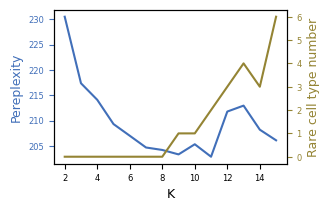

In [9]:
# Plot cell type number K versus perplexity and rare cell type number
cell_type_num = df_deconvolution_data.iloc[:, 0]
ppl = df_deconvolution_data.iloc[:, 2]
rare_cell_type_num = df_deconvolution_data.iloc[:, 1]
visualize_lineplot(cell_type_num, ppl, rare_cell_type_num)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

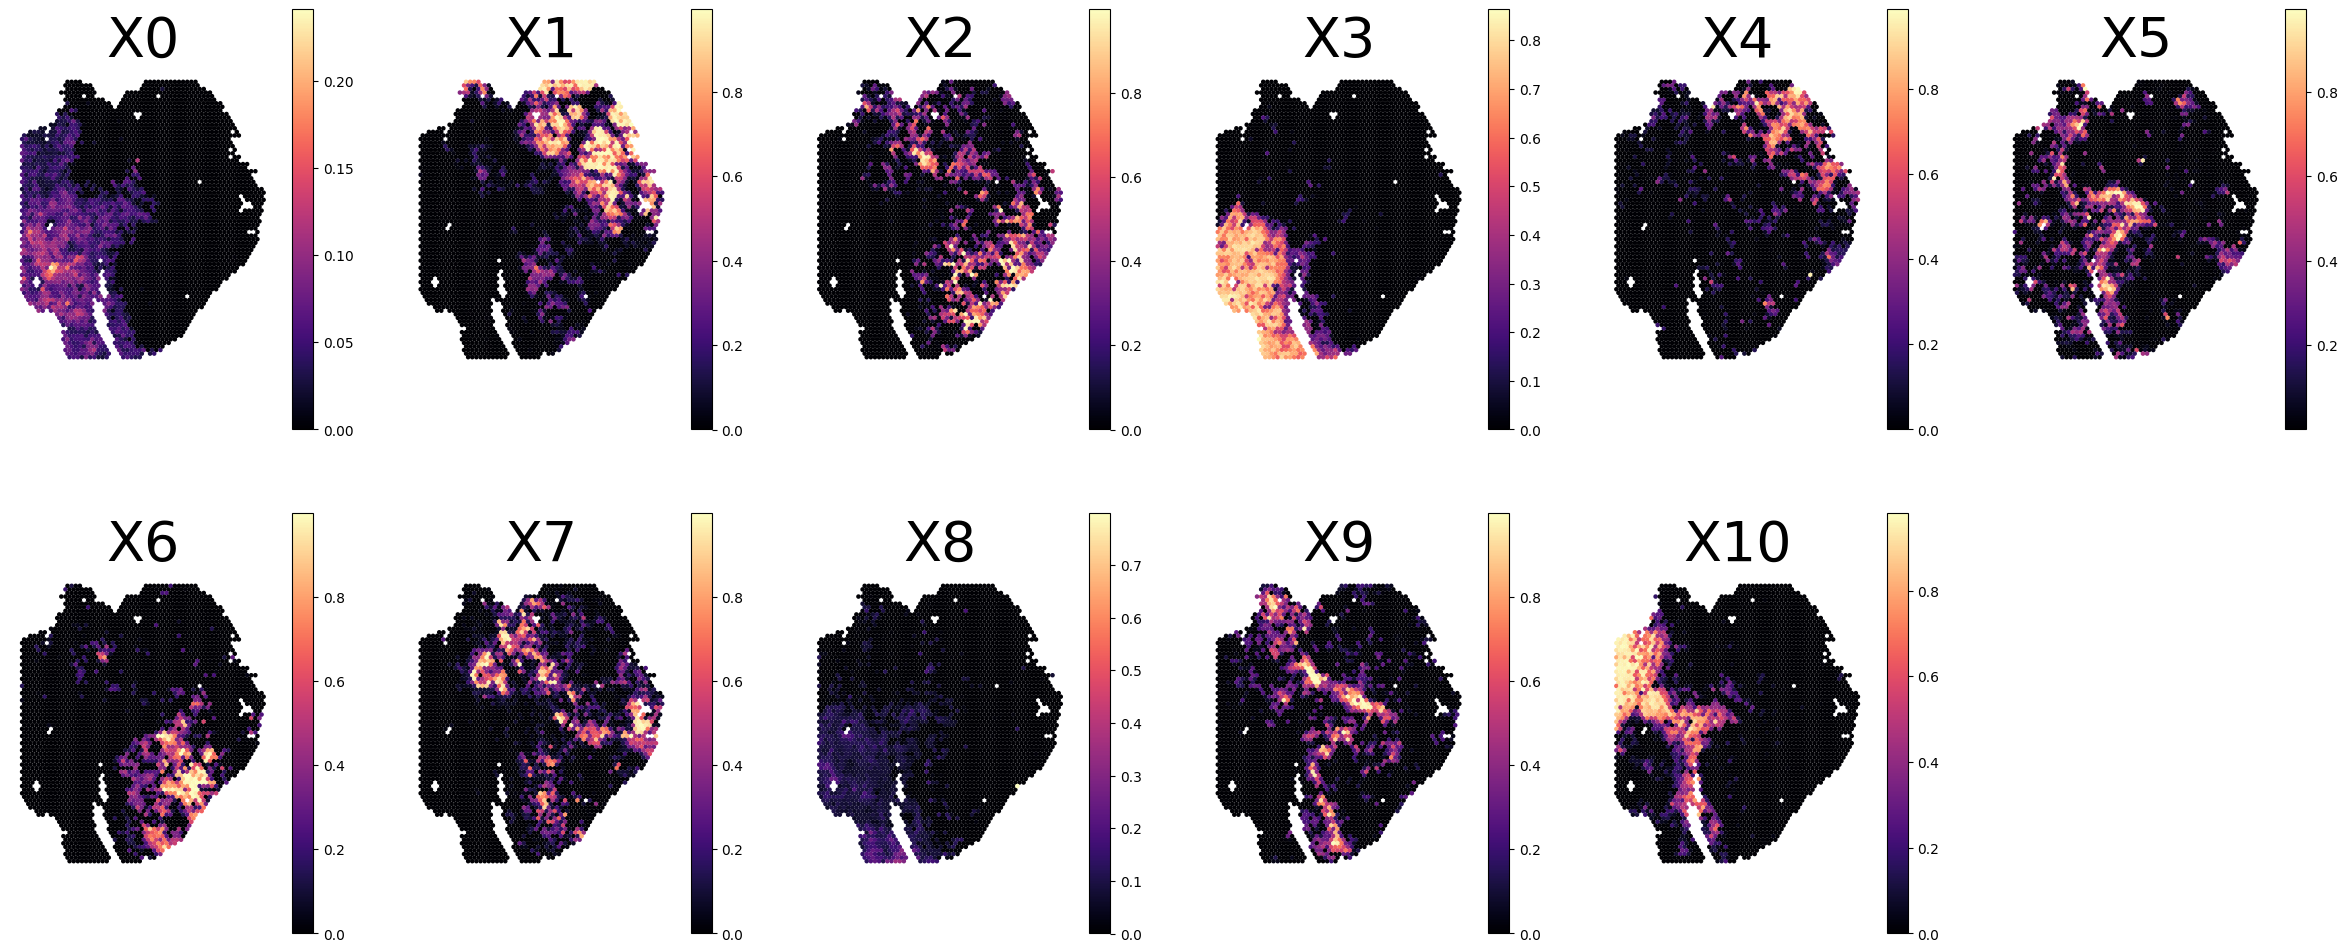

In [10]:
# Choose a suitable cell_type_num for further visualization (The optimal cell type number K is determined at the point where reaches the lowest perplexity while minimizing the rare cell type number ideally. It is reconmmended to choose the cell type number with a low perplexity but not very high rare cell type number (less than 3). Moreover, the user can choose the optimal K with the help their biology knowledge.)
cell_type_num = 11
df_pred_ = pd.read_csv(results_dir + f'/prediction_save/cell_type_num_{cell_type_num}/pred.csv')
df_pos_ = df_pp_data.iloc[:, 1:3]
celltype_visualization_visium(df_pred_, df_pos_, col_num=6)